# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-03-11.ipynb)

## Section 03: Basics of Diffusion Model

最先端の画像生成 AI である拡散モデル (diffusion model) の基礎について導入します。

### Lecture 11: Beyond Conventional GANs

本実習では classifier-free guidance について扱います。

拡散モデルによる画像生成が注目される前までは敵対的生成ネットワーク (generative adversarial network; GAN) が一世を風靡しておりました。ノイズ除去拡散確率モデル (denoising diffusion probabilistic model; DDPM) の登場により、一定の限界が見え始めてきた GAN を超える画像生成手法として注目を集め、現在の画像生成 AI ブームとなっております。

拡散モデルによって GAN を超える画像生成を実現する上で生成品質をコントロールする手法として分類器不使用誘導 (classifier-free guidance; CFG) が提案されました。以下、非常にシンプルに画像生成中の拡散モデルを誘導する本手法について実習します。

## セットアップ

## GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Sat Jun 17 14:03:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.8 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


今回の画像生成時には勾配情報は必要ないため、以下のようにして勾配は計算しないように設定。この設定で GPU メモリの節約もできます。

In [ ]:
torch.set_grad_enabled(False)

以下は Stable Diffusion によるテキストからの画像生成の順序です。以下の手順からなります:
- 各種パラメータを設定
- 入力される値を確認
- プロンプトを CLIP text encoder でベクトル化してテキストベクトルを取得
- 逆拡散過程におけるステップ情報を準備
- 潜在データを準備
- その他の画像生成に必要な準備
- 逆拡散過程におけるノイズ除去ループ
- デコーダで潜在データを画像へ変換

In [ ]:
# seed 値を固定して結果を再現可能にします。
generator = torch.Generator("cuda").manual_seed(19950815)

# 0. 各種パラメータを設定
h = 512 # 生成画像の高さ
w = 512 # 生成画像の幅

prompt = "A photograph of an astronaut riding a horse" # 画像生成する際の条件プロンプト
num_inference_steps = 50 # 逆拡散過程のステップ数
eta = 0.0 # DDIM における eta (η) の値
guidance_scale = 7.5 # Classifier-free Guidance の guidance scale

batch_size = 1 # 今回は画像 1 枚を生成
device = pipe._execution_device # ここは GPU を使用する場合 "cuda" が入ってくる

# 1. 入力される値を確認。正しくなければエラーが出ます
pipe.check_inputs(prompt=prompt, height=h, width=w, callback_steps=1)

# 2. プロンプトを CLIP text encoder でベクトル化してテキストベクトルを取得
cond_text_inputs = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
cond_text_input_ids = cond_text_inputs.input_ids

text_encoder_output = pipe.text_encoder(
    cond_text_input_ids.to(device),
)
cond_prompt_embeds = text_encoder_output.last_hidden_state
cond_prompt_embeds = cond_prompt_embeds.to(dtype=pipe.text_encoder.dtype, device=device)

# Classifier-free guidance のために null token でベクトル化してテキストベクトルを取得
uncond_tokens = [""] * batch_size
max_length = cond_prompt_embeds.shape[1]
uncond_text_inputs = pipe.tokenizer(
    uncond_tokens,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)
uncond_text_input_ids = uncond_text_inputs.input_ids
text_encoder_output = pipe.text_encoder(
    uncond_text_input_ids.to(device)
)
uncond_prompt_embeds = text_encoder_output.last_hidden_state
uncond_prompt_embeds = uncond_prompt_embeds.to(dtype=pipe.text_encoder.dtype, device=device)

# 3. 逆拡散過程におけるステップ情報を準備
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

# 4. 潜在データを準備
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    batch_size=batch_size,
    num_channels_latents=num_channels_latents,
    height=h,
    width=w,
    dtype=cond_prompt_embeds.dtype,
    device=device,
    generator=generator,
)

# 5. その他の画像生成に必要な準備
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)

In [ ]:
# 6. 逆拡散過程におけるノイズ除去ループ

progress_bar = pipe.progress_bar(total=num_inference_steps)
for i, t in enumerate(timesteps):
    latent_model_input = pipe.scheduler.scale_model_input(latents, t)

    # U-Net を使ってノイズを予測
    cond_noise_pred = pipe.unet(
        latent_model_input,
        t,
        encoder_hidden_states=cond_prompt_embeds,
    ).sample

    uncond_noise_pred = pipe.unet(
        latent_model_input,
        t,
        encoder_hidden_states=uncond_prompt_embeds,
    ).sample

    #
    # Classifier-free Guidance を実施
    # CLIP text encoder にプロンプトを入力したものと、何も入力しないものから計算
    #
    noise_pred = uncond_noise_pred + guidance_scale * (cond_noise_pred - uncond_noise_pred)

    # 現在の状態 (x_t) から一つ前のステップの状態 (x_{t-1}) を予測
    latents = pipe.scheduler.step(
        noise_pred,
        t,
        latents,
        **extra_step_kwargs
    ).prev_sample

    if i == len(timesteps) - 1 or (i + 1) % pipe.scheduler.order == 0:
        progress_bar.update()

# 7. 潜在データから画像へデコード
image = pipe.decode_latents(latents)

# 8. NSFW (よくない画像) をフィルタリング
image, has_nsfw_concept = pipe.run_safety_checker(image, device, cond_prompt_embeds.dtype)

# 9. 可視化のために numpy 形式から PIL 形式へ変換
image = pipe.numpy_to_pil(image)

  0%|          | 0/50 [00:00<?, ?it/s]

生成された画像を確認してみます。

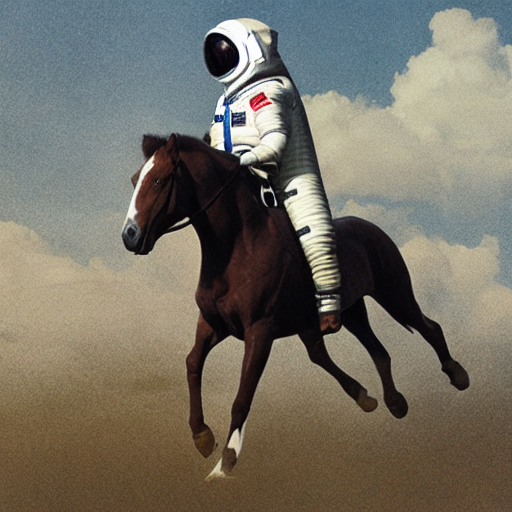

In [ ]:
image[0]

### Guidance scale を変えたときの生成画像の変化の確認

`guidance scale` を 0 に設定した場合: プロンプトによる条件付けを無視


  0%|          | 0/50 [00:00<?, ?it/s]

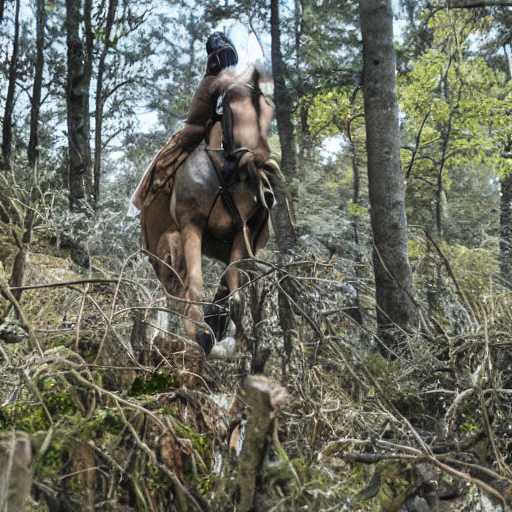

In [ ]:
# seed 値を固定して結果を再現可能にします。
generator = torch.Generator("cuda").manual_seed(19950815)

pipe(prompt=prompt, guidance_scale=0, generator=generator).images[0]

`guidance scale` を 7.5 に設定した場合: Stable Diffusion のデフォルトと同値 (上記の結果と同じ結果が得られます)

  0%|          | 0/50 [00:00<?, ?it/s]

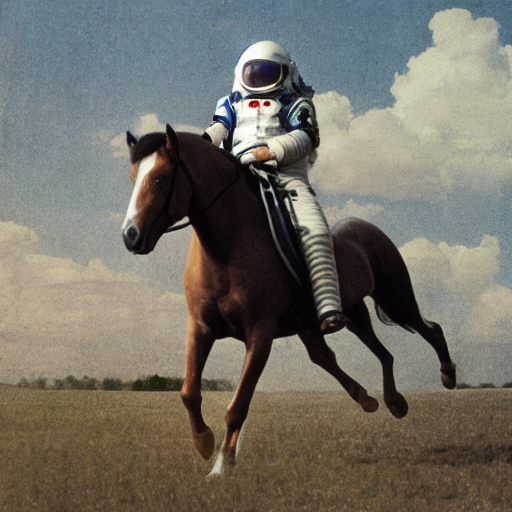

In [ ]:
# seed 値を固定して結果を再現可能にします。
generator = torch.Generator("cuda").manual_seed(19950815)

pipe(prompt=prompt, guidance_scale=7.5, generator=generator).images[0]

`guidance scale` を 20.0 に設定した場合: プロンプトによる条件付けをより強制

  0%|          | 0/50 [00:00<?, ?it/s]

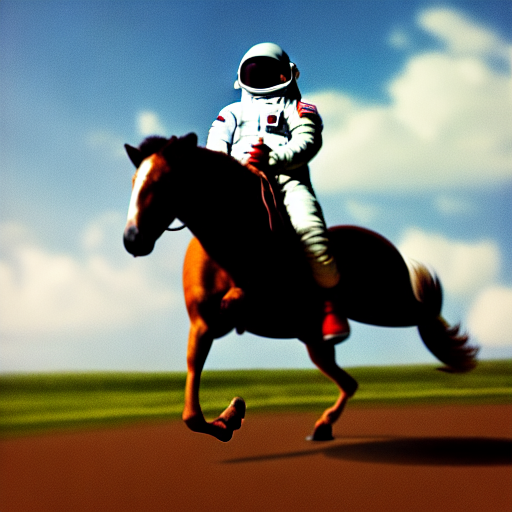

In [ ]:
# seed 値を固定して結果を再現可能にします。
generator = torch.Generator("cuda").manual_seed(19950815)

pipe(prompt=prompt, guidance_scale=20.0, generator=generator).images[0]

## まとめ

テキストからの画像生成モデルで重要なテクニックである classifier-free guidance の動作確認をしました。guidance scale を 0 からはじめ、Stable Diffusion のデフォルト値、それを超える大きな値を入れたときにそれぞれどのような画像が生成されるかを確認しました。よりイメージした生成画像をモデルに出力してもらうために、このパラメータを調整することも検討してみてください。